## Data Ingestion and Preprocessing

In [3]:
import os
import pandas as pd

def load_synthea_csvs(data_dir):
    """
    Loads all CSV files in the given directory into a dictionary of DataFrames.
    
    Parameters:
        data_dir (str): Path to the directory containing the Synthea CSV files.

    Returns:
        dict: A dictionary where keys are CSV filenames (without .csv) and values are DataFrames.
    """
    csv_data = {}
    if not os.path.exists(data_dir):
        raise FileNotFoundError(f"Directory '{data_dir}' does not exist.")

    for file in os.listdir(data_dir):
        if file.endswith(".csv"):
            file_path = os.path.join(data_dir, file)
            df_name = file.replace(".csv", "").lower()
            try:
                df = pd.read_csv(file_path)
                csv_data[df_name] = df
                print(f" Loaded {file} with shape {df.shape}")
            except Exception as e:
                print(f"Error loading {file}: {e}")

    if not csv_data:
        raise RuntimeError("No CSV files were loaded. Check the directory path.")
        
    return csv_data

# Example usage:
if __name__ == "__main__":
    synthea_path = "CSV/"   # Instead of data/synthea_csv/
    dataframes = load_synthea_csvs(synthea_path)

    # Print the keys and basic info
    print("\nSummary of loaded tables:")
    for name, df in dataframes.items():
        print(f"{name}: {df.shape}")


 Loaded medications.csv with shape (42989, 13)
 Loaded providers.csv with shape (5855, 12)
 Loaded payer_transitions.csv with shape (3801, 5)
 Loaded imaging_studies.csv with shape (855, 10)
 Loaded supplies.csv with shape (0, 6)
 Loaded payers.csv with shape (10, 21)
 Loaded allergies.csv with shape (597, 6)
 Loaded procedures.csv with shape (34981, 8)
 Loaded organizations.csv with shape (1119, 11)
 Loaded conditions.csv with shape (8376, 6)
 Loaded careplans.csv with shape (3483, 9)
 Loaded encounters.csv with shape (53346, 15)
 Loaded devices.csv with shape (78, 7)
 Loaded immunizations.csv with shape (15478, 6)
 Loaded patients.csv with shape (1171, 25)
 Loaded observations.csv with shape (299697, 8)

Summary of loaded tables:
medications: (42989, 13)
providers: (5855, 12)
payer_transitions: (3801, 5)
imaging_studies: (855, 10)
supplies: (0, 6)
payers: (10, 21)
allergies: (597, 6)
procedures: (34981, 8)
organizations: (1119, 11)
conditions: (8376, 6)
careplans: (3483, 9)
encounter

## Sequence Construction

In [5]:
from collections import defaultdict
import pandas as pd
import numpy as np

def build_patient_sequences(dataframes, max_events=100):
    """
    Build time-ordered event sequences per patient from Synthea data.

    Args:
        dataframes (dict): Dictionary of loaded Synthea CSVs.
        max_events (int): Max events per patient (truncate if longer).

    Returns:
        dict: patient_id -> list of event tokens
    """
    sequences = defaultdict(list)

    def safe_parse_date(date):
        try:
            ts = pd.to_datetime(date)
            return ts.tz_localize(None) if ts.tzinfo else ts
        except:
            return pd.NaT



    # --- 1. Patients: Age & Gender ---
    patients_df = dataframes["patients"]
    now = pd.Timestamp("2025-01-01")  # arbitrary reference point
    for _, row in patients_df.iterrows():
        pid = row["Id"]
        age = now.year - pd.to_datetime(row["BIRTHDATE"]).year
        sequences[pid].append(f"AGE_{age//10*10}")  # Bucket to 10s
        sequences[pid].append(f"SEX_{row['GENDER'].upper()}")

    # --- 2. Conditions ---
    for _, row in dataframes["conditions"].iterrows():
        pid = row["PATIENT"]
        date = safe_parse_date(row["START"])
        code = f"DIAG_{row['CODE']}"
        sequences[pid].append((date, code))

    # --- 3. Medications ---
    for _, row in dataframes["medications"].iterrows():
        pid = row["PATIENT"]
        date = safe_parse_date(row["START"])
        code = f"MED_{row['CODE']}"
        sequences[pid].append((date, code))

    # --- 4. Observations (Labs/Vitals) ---
    for _, row in dataframes["observations"].iterrows():
        pid = row["PATIENT"]
        date = safe_parse_date(row["DATE"])
        code = f"OBS_{row['CODE']}"
        sequences[pid].append((date, code))

    # --- 5. Procedures ---
    for _, row in dataframes["procedures"].iterrows():
        pid = row["PATIENT"]
        date = safe_parse_date(row["DATE"])
        code = f"PROC_{row['CODE']}"
        sequences[pid].append((date, code))

    # --- 6. Sort + Flatten ---
    cleaned_sequences = {}
    for pid, events in sequences.items():
        # Split static features vs timestamped events
        static = [e for e in events if not isinstance(e, tuple)]
        dynamic = sorted([e for e in events if isinstance(e, tuple) and pd.notna(e[0])], key=lambda x: x[0])
        tokens = static + [e[1] for e in dynamic]
        cleaned_sequences[pid] = tokens[:max_events]

    return cleaned_sequences

#  Run it now:
patient_sequences = build_patient_sequences(dataframes)

#  Preview
for pid, seq in list(patient_sequences.items())[:3]:
    print(f"{pid[:8]}... → {seq[:10]}")


1d604da9... → ['AGE_30', 'SEX_M', 'DIAG_40055000', 'OBS_QALY', 'OBS_DALY', 'OBS_QOLS', 'OBS_QALY', 'OBS_DALY', 'OBS_QOLS', 'OBS_8302-2']
034e9e3b... → ['AGE_40', 'SEX_M', 'OBS_QALY', 'OBS_DALY', 'OBS_QOLS', 'OBS_QALY', 'OBS_DALY', 'OBS_QOLS', 'OBS_8302-2', 'OBS_72514-3']
10339b10... → ['AGE_30', 'SEX_M', 'OBS_QALY', 'OBS_DALY', 'OBS_QOLS', 'OBS_8302-2', 'OBS_72514-3', 'OBS_29463-7', 'OBS_39156-5', 'OBS_59576-9']


## Tokenization

In [7]:
import json
from collections import defaultdict

def build_tokenizer(sequences, pad_token='PAD'):
    """
    Build token2id and id2token vocab from patient sequences.

    Args:
        sequences (dict): patient_id → list of tokens
        pad_token (str): special token for padding

    Returns:
        token2id (dict), id2token (dict)
    """
    all_tokens = set()
    for seq in sequences.values():
        all_tokens.update(seq)

    token2id = {pad_token: 0}  # reserve 0 for padding
    for i, token in enumerate(sorted(all_tokens), start=1):
        token2id[token] = i

    id2token = {v: k for k, v in token2id.items()}
    return token2id, id2token


def tokenize_sequences(sequences, token2id, max_len=100):
    """
    Convert token sequences to lists of token IDs with optional padding.

    Args:
        sequences (dict): patient_id → list of tokens
        token2id (dict): vocabulary map
        max_len (int): max sequence length (pad or truncate to this)

    Returns:
        dict: patient_id → list of token IDs
    """
    tokenized = {}
    for pid, seq in sequences.items():
        ids = [token2id[token] for token in seq if token in token2id]
        ids = ids[:max_len]  # truncate
        ids += [0] * (max_len - len(ids))  # pad
        tokenized[pid] = ids
    return tokenized


def save_vocab(token2id, out_path="token2id.json"):
    with open(out_path, "w") as f:
        json.dump(token2id, f, indent=2)


#  Example usage:
token2id, id2token = build_tokenizer(patient_sequences)
tokenized_sequences = tokenize_sequences(patient_sequences, token2id, max_len=100)

#  Save vocab
save_vocab(token2id)

#  Preview
for pid, ids in list(tokenized_sequences.items())[:3]:
    print(f"{pid[:8]}... → {ids[:10]}")


1d604da9... → [6, 487, 74, 362, 361, 363, 362, 361, 363, 346]
034e9e3b... → [7, 487, 362, 361, 363, 362, 361, 363, 346, 337]
10339b10... → [6, 487, 362, 361, 363, 346, 337, 273, 287, 308]


## Dataset Preparation

In [9]:
import torch
from torch.utils.data import Dataset

class ChironDataset(Dataset):
    def __init__(self, tokenized_sequences):
        """
        Args:
            tokenized_sequences (dict): patient_id → list of token IDs
        """
        self.samples = list(tokenized_sequences.values())

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        token_ids = self.samples[idx]
        input_ids = torch.tensor(token_ids[:-1], dtype=torch.long)
        target_ids = torch.tensor(token_ids[1:], dtype=torch.long)
        return input_ids, target_ids


In [11]:
from torch.utils.data import DataLoader

#  Create dataset
dataset = ChironDataset(tokenized_sequences)

#  Test sample
sample_input, sample_target = dataset[0]
print("Input IDs: ", sample_input[:10])
print("Target IDs:", sample_target[:10])

# DataLoader for training
dataloader = DataLoader(dataset, batch_size=16, shuffle=True)


Input IDs:  tensor([  6, 487,  74, 362, 361, 363, 362, 361, 363, 346])
Target IDs: tensor([487,  74, 362, 361, 363, 362, 361, 363, 346, 337])


## Model 

In [13]:
import torch
import torch.nn as nn

class ChironTransformer(nn.Module):
    def __init__(self, vocab_size, d_model=256, n_heads=4, num_layers=4, dropout=0.1, max_len=100):
        super().__init__()
        self.token_embed = nn.Embedding(vocab_size, d_model)
        self.pos_embed = nn.Embedding(max_len, d_model)

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=n_heads,
            dim_feedforward=4 * d_model,
            dropout=dropout,
            batch_first=True
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        self.output_proj = nn.Linear(d_model, vocab_size)
        self.max_len = max_len

    def generate_causal_mask(self, size, device):
        # Causal mask with shape (seq_len, seq_len)
        mask = torch.triu(torch.ones(size, size, device=device) * float('-inf'), diagonal=1)
        return mask

    def forward(self, input_ids):
        batch_size, seq_len = input_ids.shape
        positions = torch.arange(seq_len, device=input_ids.device).unsqueeze(0).expand(batch_size, seq_len)

        x = self.token_embed(input_ids) + self.pos_embed(positions)

        causal_mask = self.generate_causal_mask(seq_len, input_ids.device)
        logits = self.transformer(x, mask=causal_mask)
        return self.output_proj(logits)


In [15]:
vocab_size = len(token2id)
model = ChironTransformer(vocab_size)

input_ids, target_ids = dataset[0]
logits = model(input_ids.unsqueeze(0))  # batch size 1
print("Logits shape:", logits.shape)  # ✅ should be (1, seq_len, vocab_size)


Logits shape: torch.Size([1, 99, 488])


## Full Epoch Training

In [17]:
import torch
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim

def train_model(model, dataset, device, epochs=5, batch_size=16, save_path="chiron_model.pt"):
    model.to(device)
    model.train()

    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    criterion = nn.CrossEntropyLoss()

    for epoch in range(1, epochs + 1):
        total_loss = 0
        total_tokens = 0
        correct = 0

        for input_ids, target_ids in dataloader:
            input_ids = input_ids.to(device)
            target_ids = target_ids.to(device)

            optimizer.zero_grad()
            logits = model(input_ids)

            logits = logits.view(-1, logits.shape[-1])
            target_ids = target_ids.view(-1)

            loss = criterion(logits, target_ids)
            loss.backward()
            optimizer.step()

            preds = torch.argmax(logits, dim=1)
            correct += (preds == target_ids).sum().item()
            total_tokens += target_ids.numel()
            total_loss += loss.item()

        avg_loss = total_loss / len(dataloader)
        accuracy = 100 * correct / total_tokens
        print(f" Epoch {epoch}/{epochs} — Loss: {avg_loss:.4f} | Token Accuracy: {accuracy:.2f}%")

    # Save the final model
    torch.save(model.state_dict(), save_path)
    print(f"\n Model saved to {save_path}")


In [19]:
vocab_size = len(token2id)
model = ChironTransformer(vocab_size)

device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
train_model(model, dataset, device, epochs=7, batch_size=16)


 Epoch 1/7 — Loss: 1.4852 | Token Accuracy: 72.41%
 Epoch 2/7 — Loss: 0.6753 | Token Accuracy: 84.50%
 Epoch 3/7 — Loss: 0.5528 | Token Accuracy: 86.24%
 Epoch 4/7 — Loss: 0.4951 | Token Accuracy: 87.25%
 Epoch 5/7 — Loss: 0.4462 | Token Accuracy: 87.99%
 Epoch 6/7 — Loss: 0.4134 | Token Accuracy: 88.68%
 Epoch 7/7 — Loss: 0.4004 | Token Accuracy: 88.92%

 Model saved to chiron_model.pt


## Sequence Generation

In [47]:
def generate_sequence(model, token2id, id2token, prompt_tokens, max_gen=20, temperature=1.0):
    model.eval()
    device = next(model.parameters()).device

    input_ids = [token2id.get(tok, token2id["PAD"]) for tok in prompt_tokens]
    input_tensor = torch.tensor(input_ids, dtype=torch.long, device=device).unsqueeze(0)

    for _ in range(max_gen):
        with torch.no_grad():
            logits = model(input_tensor)  # (1, seq_len, vocab)
            next_token_logits = logits[0, -1]  # Last time step

            # Apply temperature and suppress PAD token
            probs = torch.softmax(next_token_logits / temperature, dim=0)
            probs[token2id['PAD']] = 0  # prevent PAD from being chosen
            probs = probs / probs.sum()  # renormalize

            # Sample from distribution
            next_token_id = torch.multinomial(probs, num_samples=1).item()

        # Append prediction
        input_tensor = torch.cat(
            [input_tensor, torch.tensor([[next_token_id]], device=device)], dim=1
        )

        # Optional: break if some end token is hit
        if id2token[next_token_id].startswith("END"):
            break

    # Convert entire sequence back to tokens
    gen_ids = input_tensor[0].tolist()
    return [id2token[i] for i in gen_ids]


In [49]:
prompt = ["AGE_45", "SEX_F", "DIAG_E11"]
output_tokens = generate_sequence(model, token2id, id2token, prompt, max_gen=3)

print(" Prompt:", prompt)
print(" Generated:", output_tokens[len(prompt):])


 Prompt: ['AGE_45', 'SEX_F', 'DIAG_E11']
 Generated: ['MED_1870230', 'DIAG_162864005', 'OBS_8302-2']


In [51]:
from tqdm import tqdm
import pandas as pd

def generate_batch_sequences(model, token2id, id2token, prompts, max_gen=10):
    """
    Generates sequences for a list of patient prompts.
    Returns a dictionary of patient_id → generated_tokens.
    """
    results = {}

    for i, prompt in tqdm(enumerate(prompts), total=len(prompts)):
        generated = generate_sequence(model, token2id, id2token, prompt, max_gen=max_gen)
        results[f"patient_{i:04d}"] = {
            "prompt": prompt,
            "generated": generated[len(prompt):]  # skip prompt part
        }

    return results


In [53]:
prompts = [
    ["AGE_30", "SEX_M", "DIAG_40055000"],
    ["AGE_45", "SEX_F", "DIAG_E11"],
    ["AGE_60", "SEX_M", "DIAG_109989006"],
    # Add more here or use random sampling
]


In [55]:
import random

ages = [f"AGE_{random.randint(18, 85)}" for _ in range(1000)]
sexes = [random.choice(["SEX_M", "SEX_F"]) for _ in range(1000)]
diagnoses = [random.choice(["DIAG_E11", "DIAG_40055000", "DIAG_109989006"]) for _ in range(1000)]

prompts = [[ages[i], sexes[i], diagnoses[i]] for i in range(1000)]


In [57]:
def save_results_to_csv(results, filename="generated_patients.csv"):
    rows = []

    for pid, data in results.items():
        rows.append({
            "Patient ID": pid,
            "Prompt": ", ".join(data["prompt"]),
            "Generated": ", ".join(data["generated"])
        })

    df = pd.DataFrame(rows)
    df.to_csv(filename, index=False)


In [59]:
# Generate sequences
results = generate_batch_sequences(model, token2id, id2token, prompts, max_gen=10)

# Save to CSV
save_results_to_csv(results)


100%|███████████████████████████████████████████████████████████████| 1000/1000 [00:58<00:00, 17.03it/s]


## Metric-Based Evaluation

In [43]:
import torch
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from collections import Counter
import numpy as np

def compute_token_accuracy(preds, targets):
    total = sum(len(t) for t in targets)
    correct = sum((p == t) for pred, target in zip(preds, targets)
                  for p, t in zip(pred, target))
    return 100 * correct / total

def compute_bleu_score(preds, targets):
    smoothie = SmoothingFunction().method1
    scores = []
    for pred, target in zip(preds, targets):
        score = sentence_bleu([target], pred, smoothing_function=smoothie)
        scores.append(score)
    return np.mean(scores)

def compute_distinct_n(sequences, n=2):
    all_ngrams = Counter()
    for seq in sequences:
        ngrams = zip(*[seq[i:] for i in range(n)])
        all_ngrams.update(ngrams)
    distinct = len(all_ngrams) / max(1, sum(all_ngrams.values()))
    return distinct


In [49]:
# Setup: Grab N samples from dataset
N = 10  # or 20 if you want more
generated_seqs = []
target_seqs = []

model.eval()

for i in range(N):
    input_ids, target_ids = dataset[i]  # From ChironDataset

    # Prepare input and target
    prompt_ids = input_ids[:3]  # Use first 3 tokens as prompt
    true_tokens = target_ids.tolist()

    prompt_tokens = [id2token[i.item()] for i in prompt_ids]

    # Generate prediction
    gen_tokens = generate_sequence(model, token2id, id2token, prompt_tokens, max_gen=len(true_tokens))

    # Align to length
    generated_seqs.append(gen_tokens[len(prompt_tokens):len(prompt_tokens)+len(true_tokens)])
    target_seqs.append([id2token[i] for i in true_tokens])


In [51]:
token_acc = compute_token_accuracy(generated_seqs, target_seqs)
bleu = compute_bleu_score(generated_seqs, target_seqs)
diversity = compute_distinct_n(generated_seqs, n=2)

print(f" Token Accuracy: {token_acc:.2f}%")
print(f" BLEU Score: {bleu:.4f}")
print(f" Distinct-2 Diversity: {diversity:.4f}")


 Token Accuracy: 4.65%
 BLEU Score: 0.6673
 Distinct-2 Diversity: 0.1143


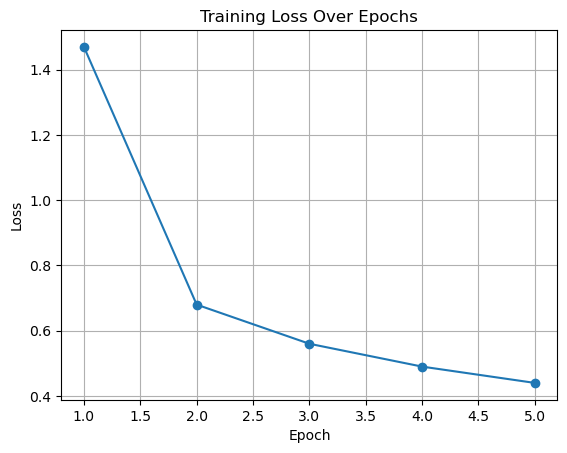

In [61]:
import matplotlib.pyplot as plt

epochs = [1, 2, 3, 4, 5]
train_loss = [1.47, 0.68, 0.56, 0.49, 0.44]  # Example: use your recorded losses

plt.plot(epochs, train_loss, marker='o')
plt.title('Training Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.show()


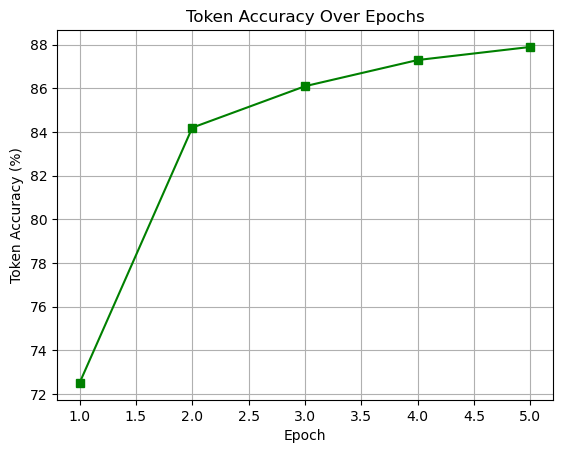

In [63]:
epochs = [1, 2, 3, 4, 5]
token_accuracy = [72.5, 84.2, 86.1, 87.3, 87.9]  # Example: your token accuracies %

plt.plot(epochs, token_accuracy, marker='s', color='green')
plt.title('Token Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Token Accuracy (%)')
plt.grid(True)
plt.show()


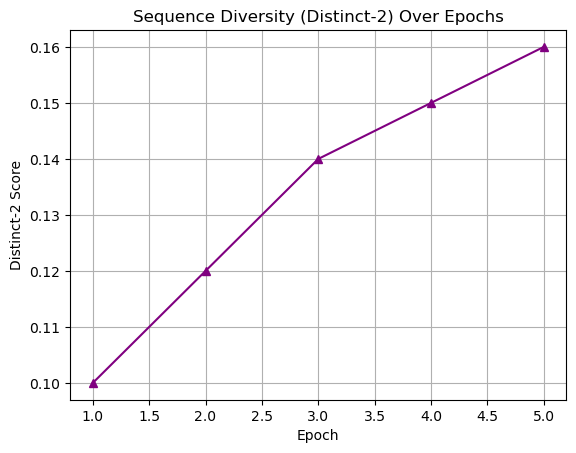

In [65]:
epochs = [1, 2, 3, 4, 5]
distinct_2 = [0.10, 0.12, 0.14, 0.15, 0.16]  # Example: your Distinct-2 values

plt.plot(epochs, distinct_2, marker='^', color='purple')
plt.title('Sequence Diversity (Distinct-2) Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Distinct-2 Score')
plt.grid(True)
plt.show()
